In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    roc_curve, auc
)

import shap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

sns.set(style="whitegrid", palette="pastel", color_codes=True)

# Import Data

In [2]:
# ========== Input Data ==========
df = pd.read_csv("heart.csv")
df_copy = df.copy()

# Explortary Data Analysis

## 1. Basic Information

In [3]:
# ========== Basic Information ==========
print("\n================ DATA HEAD ================")
display(df_copy.head())

print("\n================ DATA INFO ================")
print(df_copy.info())

print("\n================ DESCRIPTIVE STATS ================")
display(df_copy.describe())

print("\n================ MISSING VALUES ================")
print(df_copy.isnull().sum())


================ DATA HEAD ================


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0



================ DATA INFO ================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

================ DESCRIPTIVE STATS ================


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000



================ MISSING VALUES ================
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


## 2. Numerical Feature Distribution

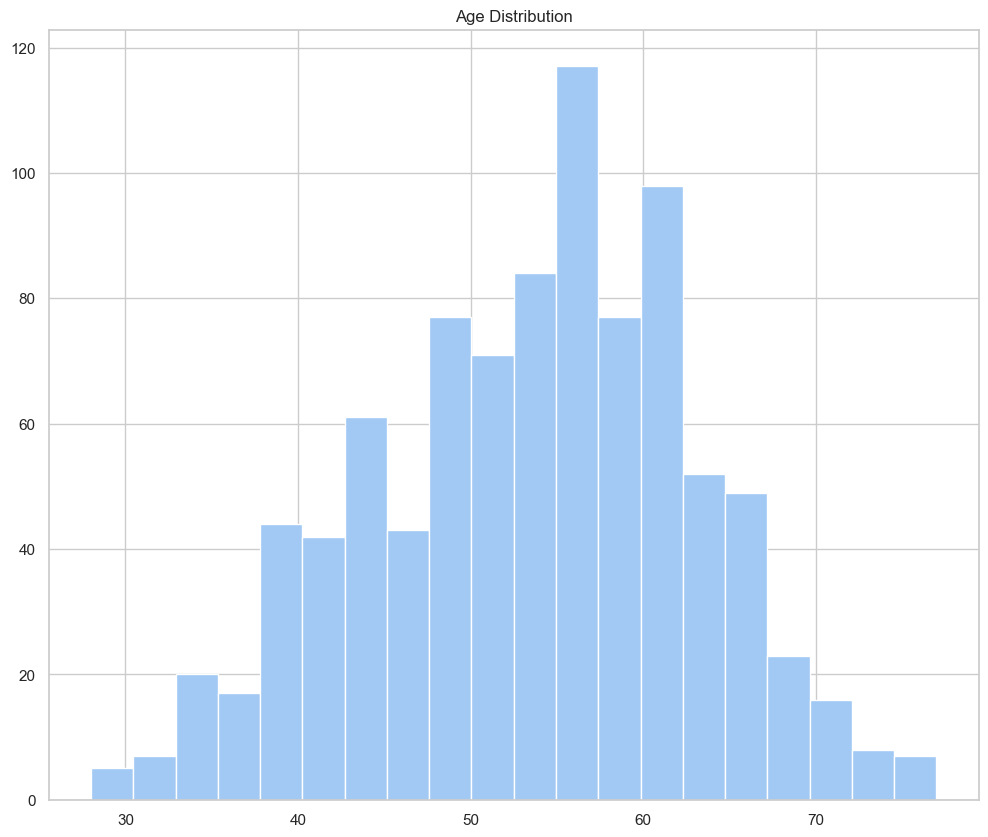

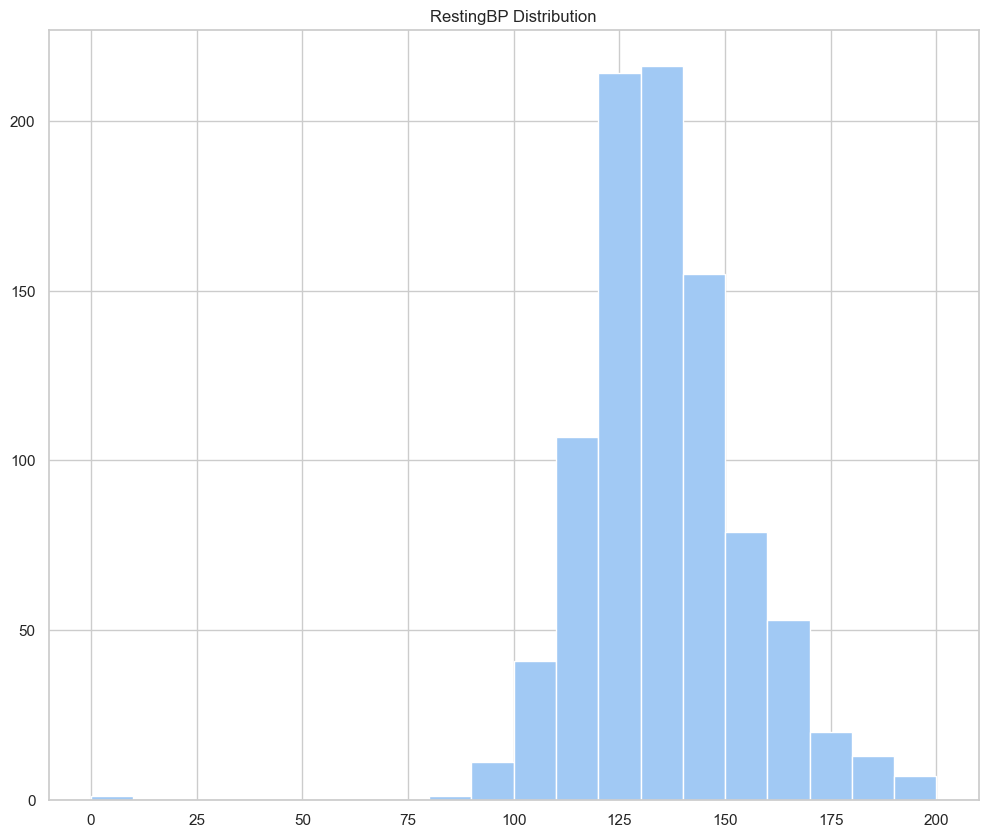

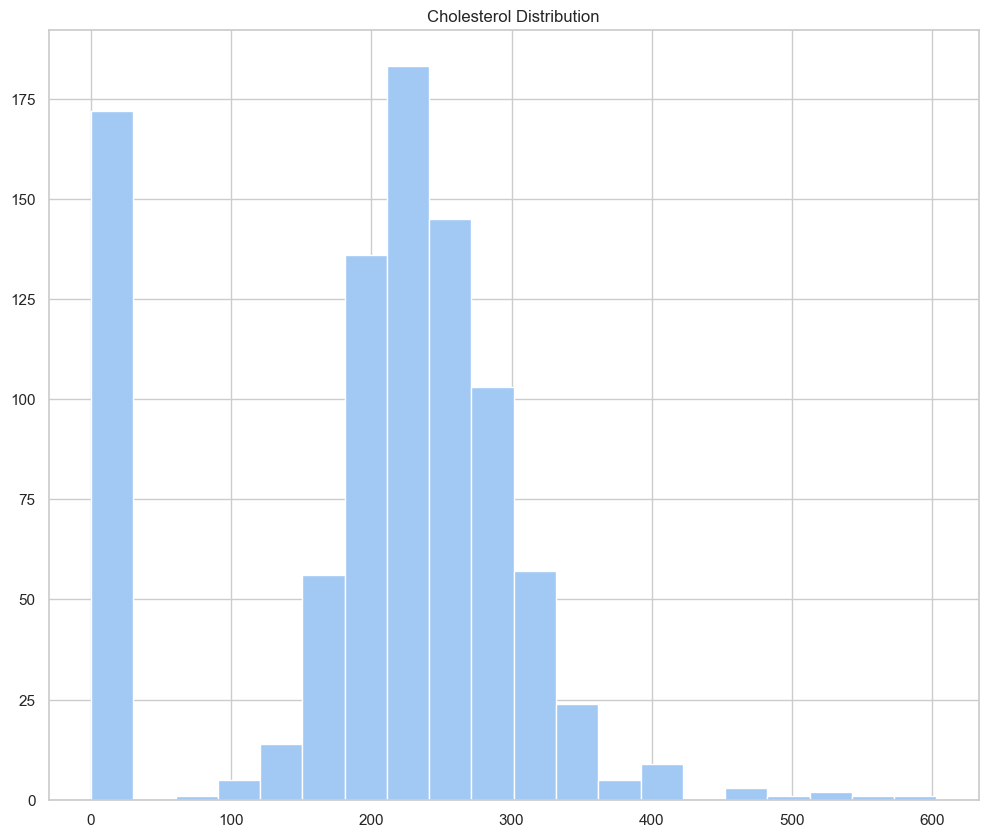

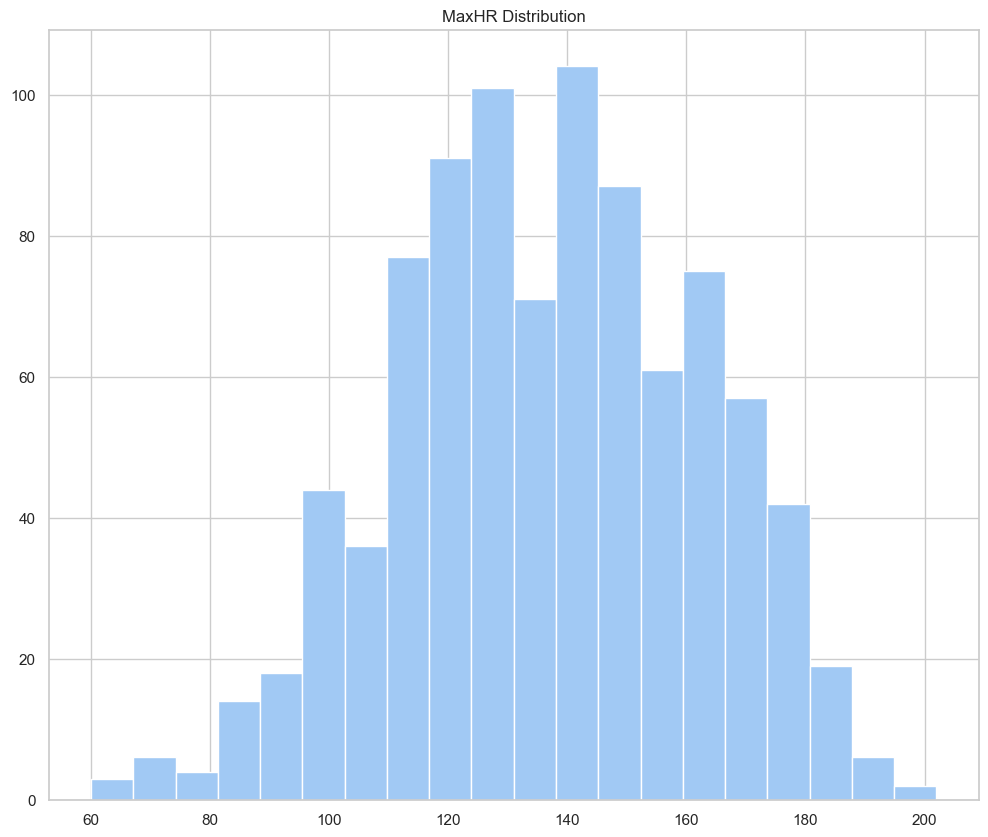

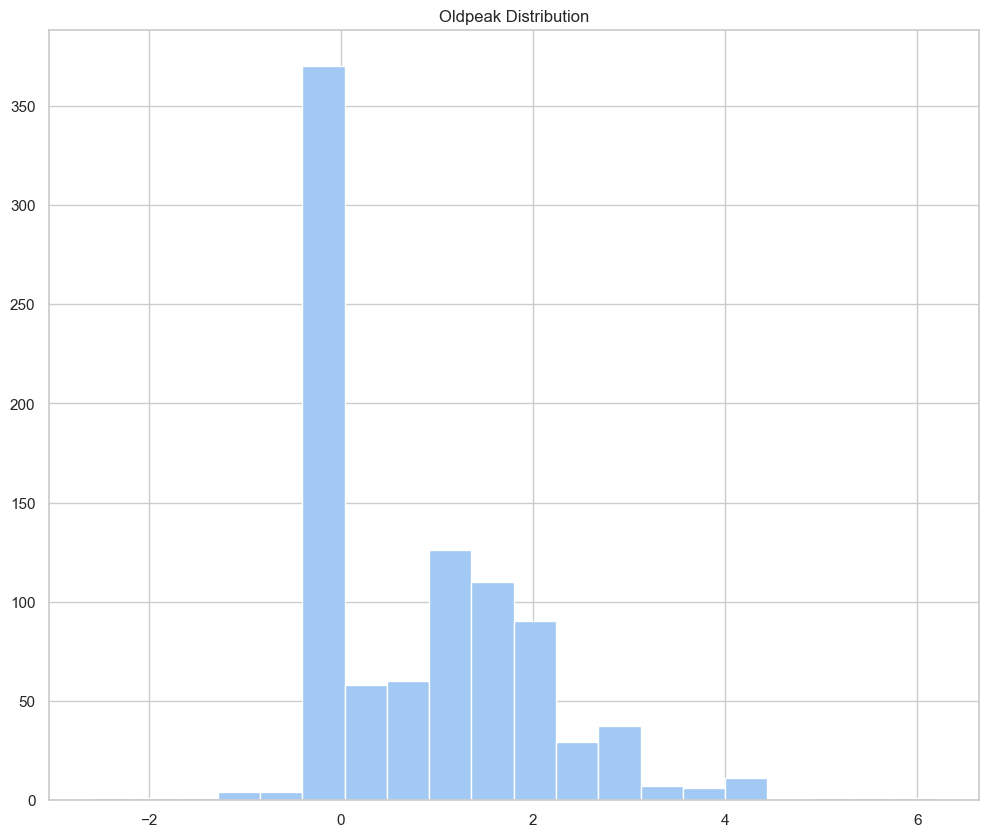

In [4]:
numeric_cols = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

for col in numeric_cols:
    df_copy[col].hist(figsize=(12, 10), bins=20)
    plt.title(f"{col} Distribution")
    plt.savefig(f"{col} Distribution.pdf", format='pdf')
    plt.show()

## 3. Numerical Feature vs Response

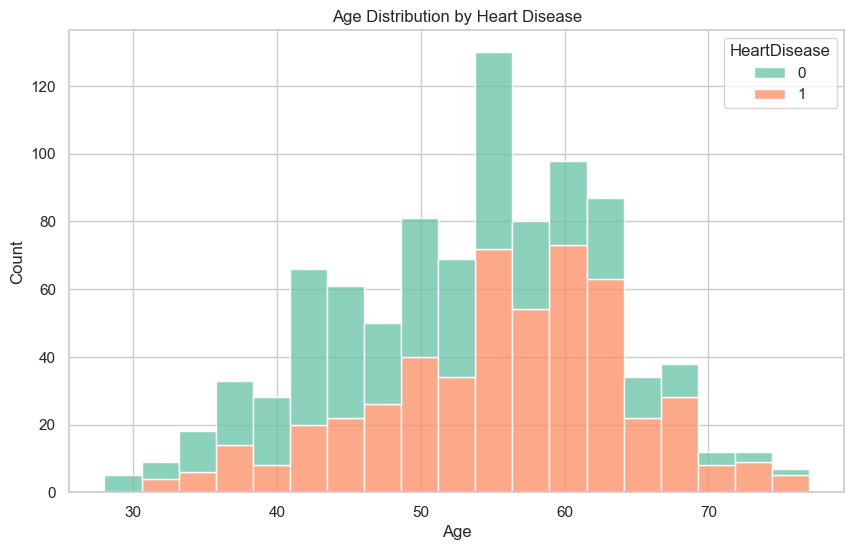

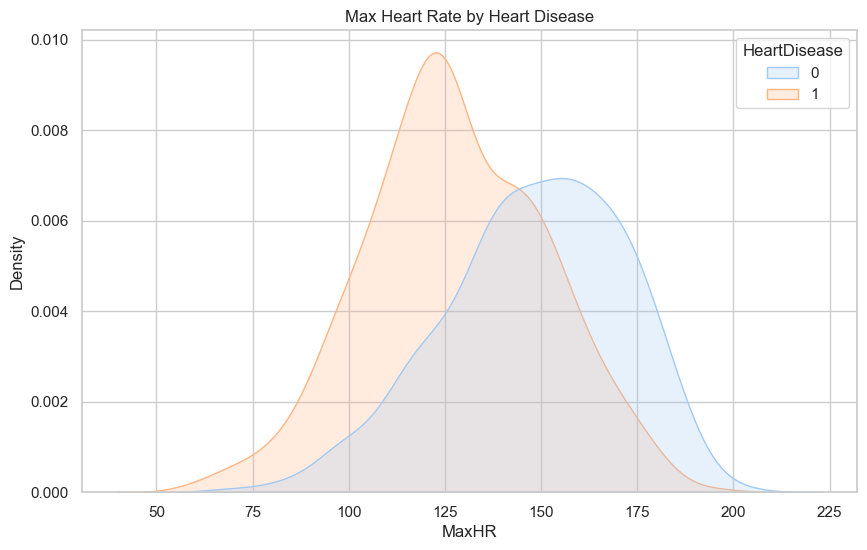

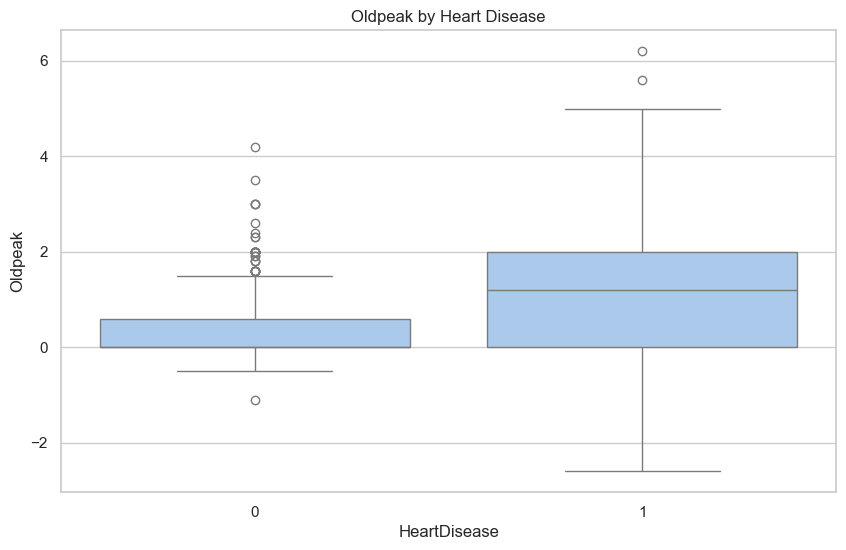

In [5]:
# ========== Heart Disease vs Age ==========
plt.figure(figsize=(10, 6))
sns.histplot(data=df_copy, x="Age", hue="HeartDisease", multiple="stack", palette="Set2")
plt.title("Age Distribution by Heart Disease")
plt.savefig('Age Distribution by Heart Disease.pdf', format='pdf')
plt.show()

# ========== Heart Disease vs MaxHR ==========
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_copy, x="MaxHR", hue="HeartDisease", fill=True)
plt.title("Max Heart Rate by Heart Disease")
plt.savefig('Max Heart Rate by Heart Disease.pdf', format='pdf')
plt.show()

# ========== Heart Disease vs Oldpeak ==========
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_copy, x="HeartDisease", y="Oldpeak")
plt.title("Oldpeak by Heart Disease")
plt.savefig('Oldpeak by Heart Disease.pdf', format='pdf')
plt.show()

## 4. Numerical Feature Distribution

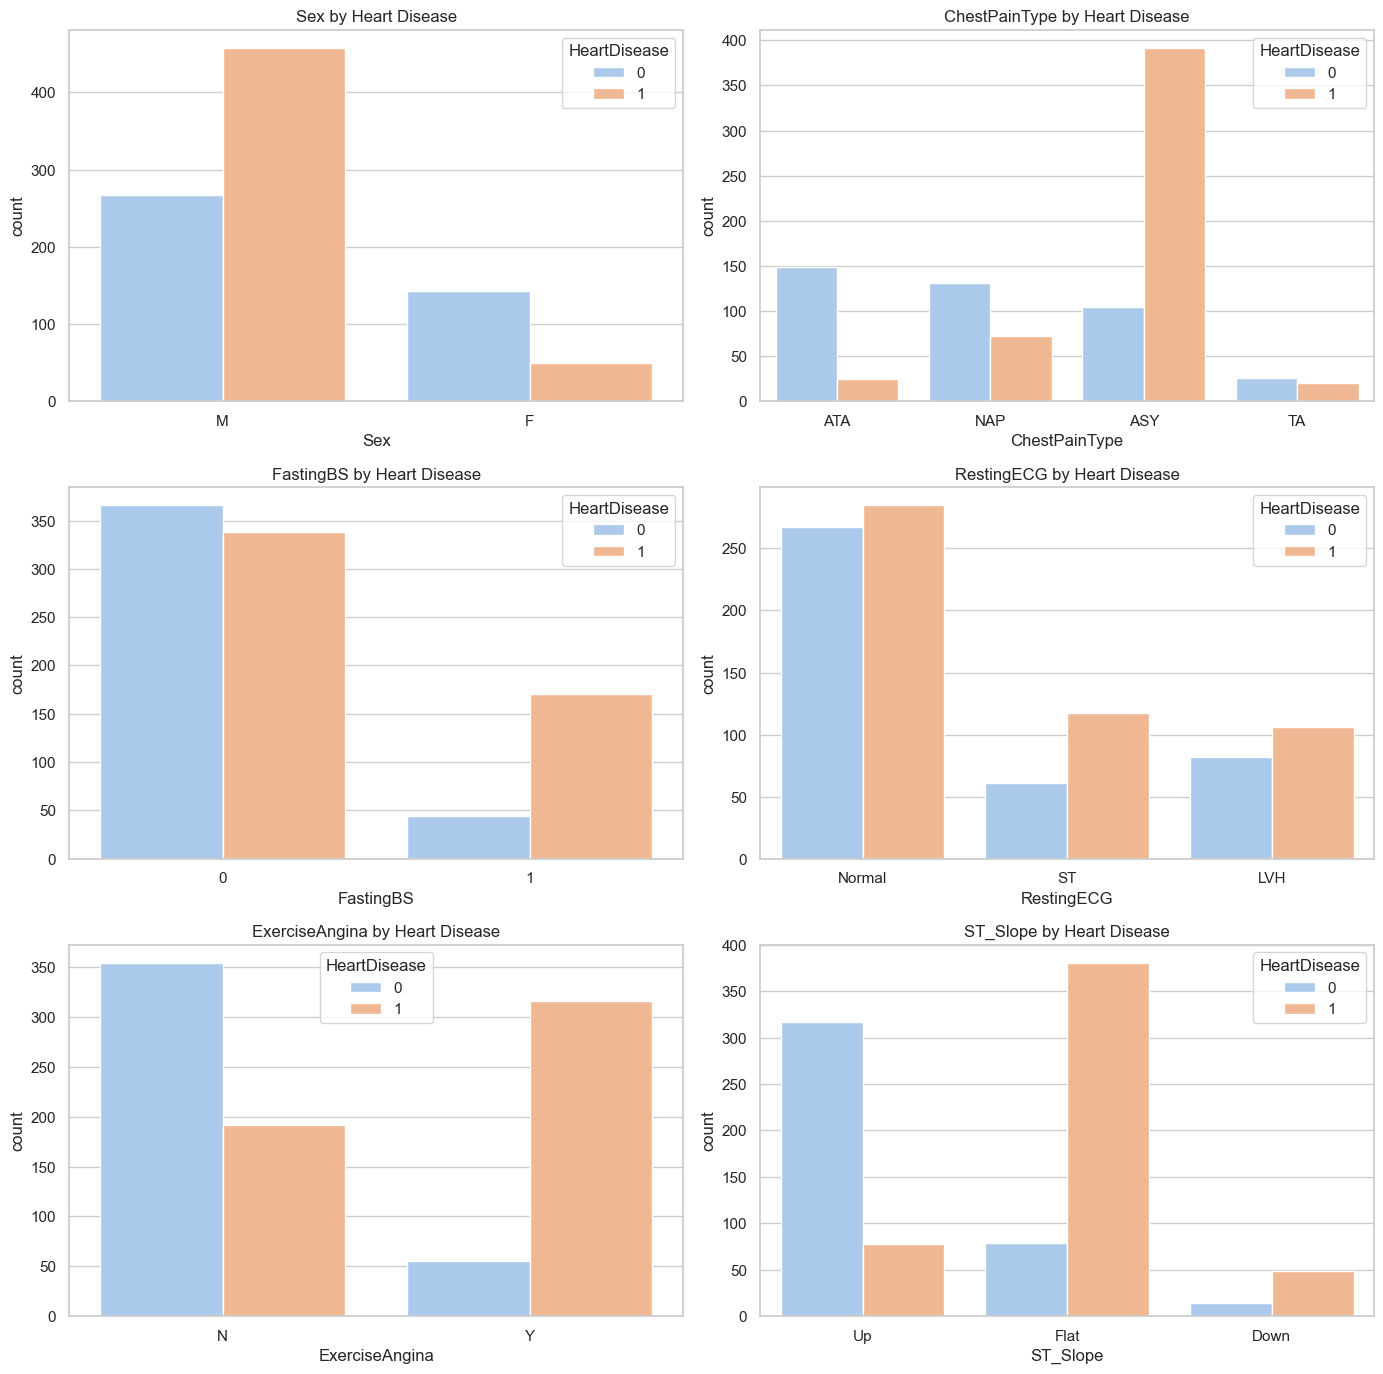

In [6]:
# ========== Categorical Features ==========
cat_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]

plt.figure(figsize=(14, 18))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(4, 2, i)
    sns.countplot(data=df_copy, x=col, hue="HeartDisease")
    plt.title(f"{col} by Heart Disease")

plt.tight_layout()
plt.savefig('categorical_distribution.pdf', format='pdf')
plt.show()




## 5. Correlation Information

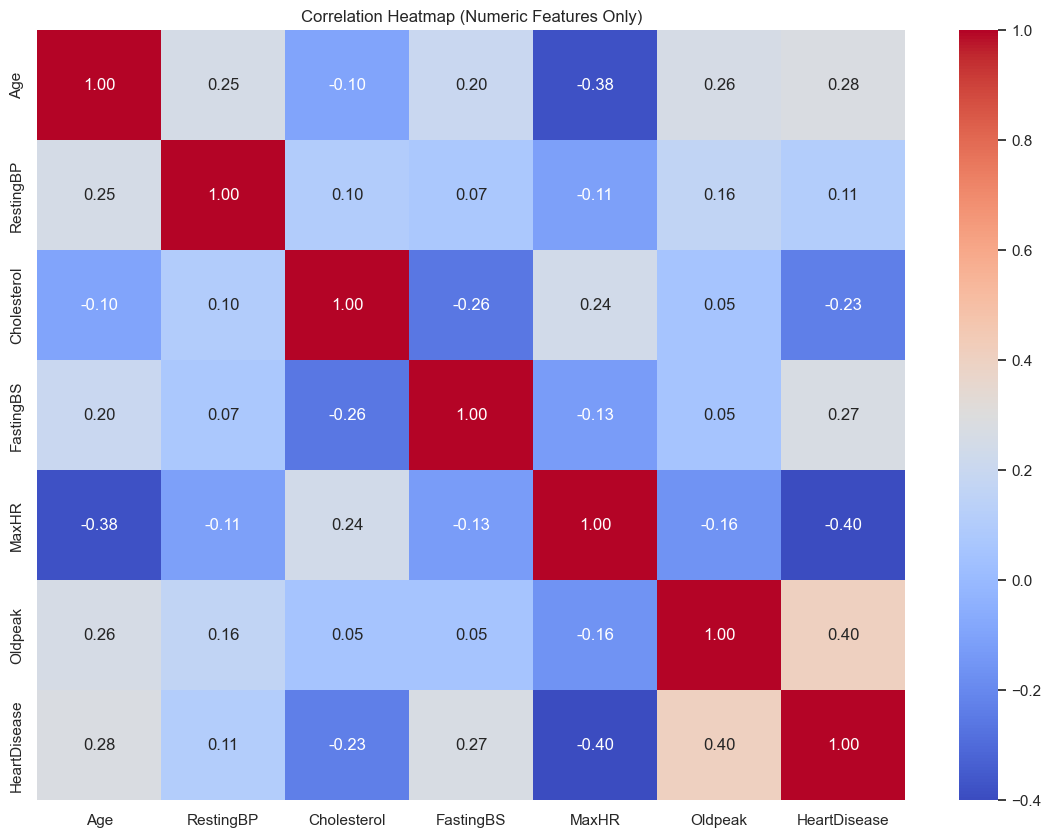


================ CORRELATION WITH TARGET ================
HeartDisease    1.000000
Oldpeak         0.403951
Age             0.282039
FastingBS       0.267291
RestingBP       0.107589
Cholesterol    -0.232741
MaxHR          -0.400421
Name: HeartDisease, dtype: float64


In [7]:
# ========== Correlation Heatmap ==========
numeric_df = df_copy.select_dtypes(include=[int, float])

plt.figure(figsize=(14, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.savefig('Correlation Heatmap.pdf', format='pdf')
plt.show()

print("\n================ CORRELATION WITH TARGET ================")
print(numeric_df.corr()["HeartDisease"].sort_values(ascending=False))

## 6. Explore Bin Operation for Numerical Feature

C:\Users\dengrh\AppData\Local\Temp\ipykernel_412\3972476441.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_vals = df_copy.groupby("bin")["HeartDisease"].mean()


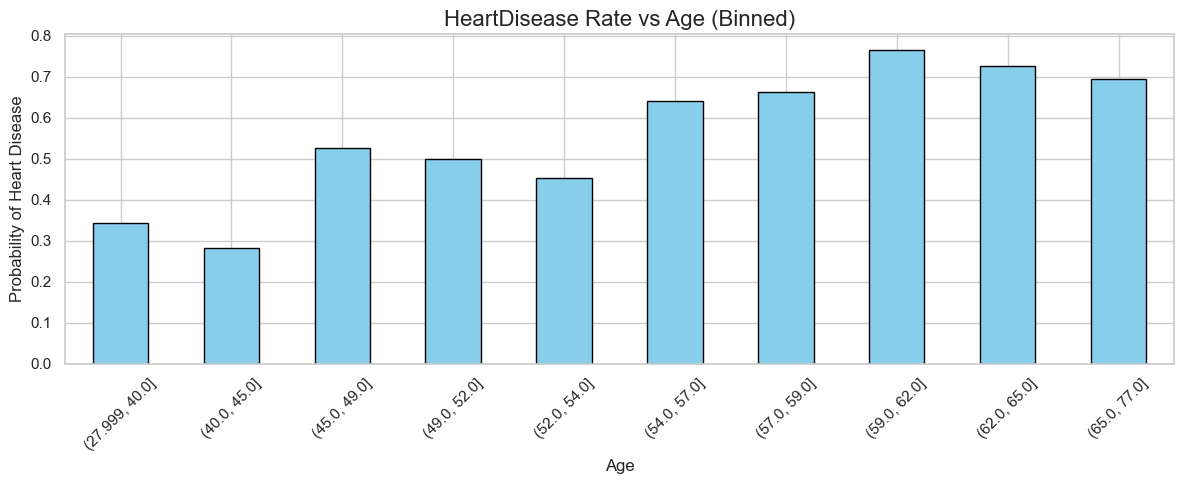

C:\Users\dengrh\AppData\Local\Temp\ipykernel_412\3972476441.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_vals = df_copy.groupby("bin")["HeartDisease"].mean()


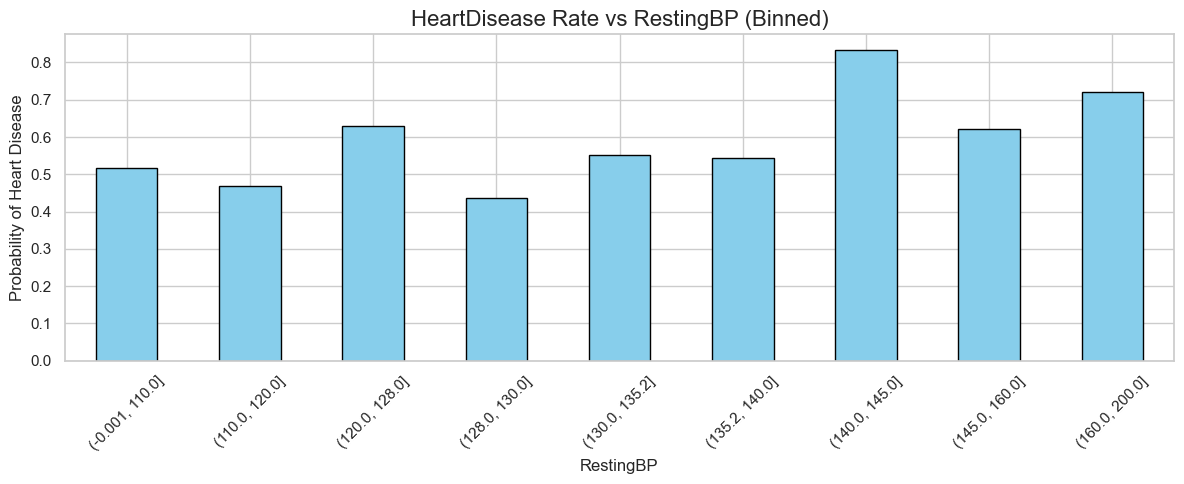

C:\Users\dengrh\AppData\Local\Temp\ipykernel_412\3972476441.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_vals = df_copy.groupby("bin")["HeartDisease"].mean()


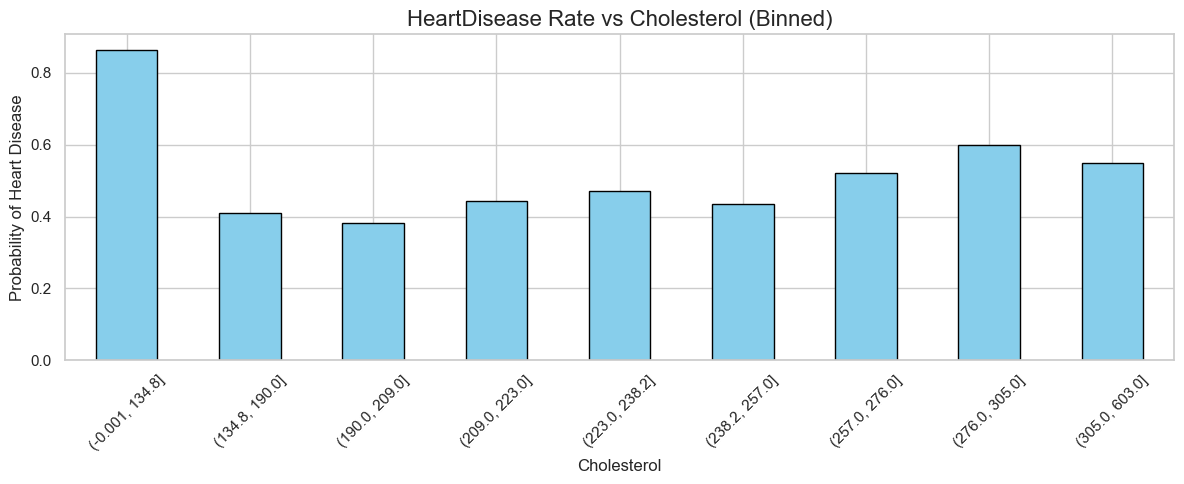

C:\Users\dengrh\AppData\Local\Temp\ipykernel_412\3972476441.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_vals = df_copy.groupby("bin")["HeartDisease"].mean()


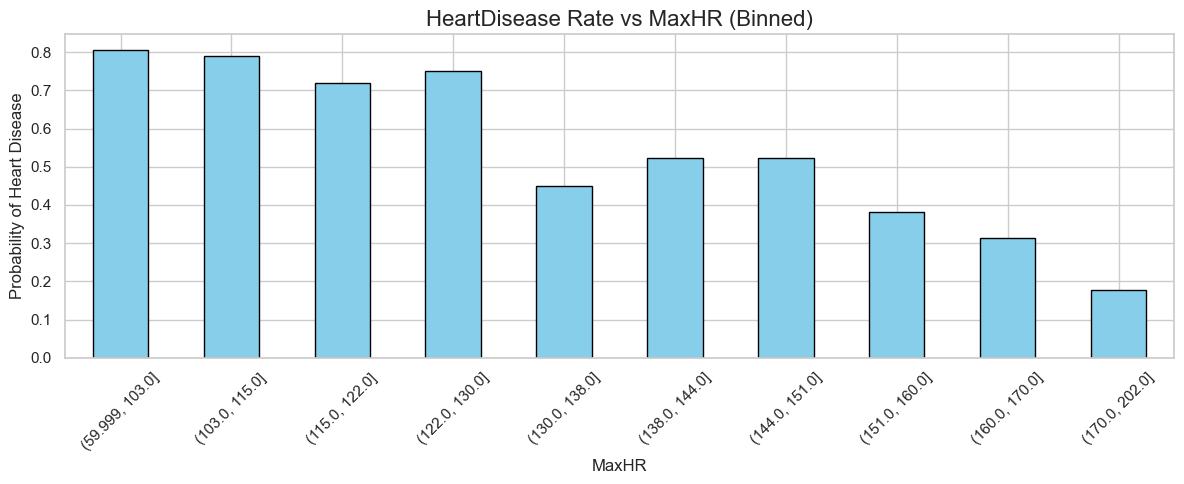

C:\Users\dengrh\AppData\Local\Temp\ipykernel_412\3972476441.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_vals = df_copy.groupby("bin")["HeartDisease"].mean()


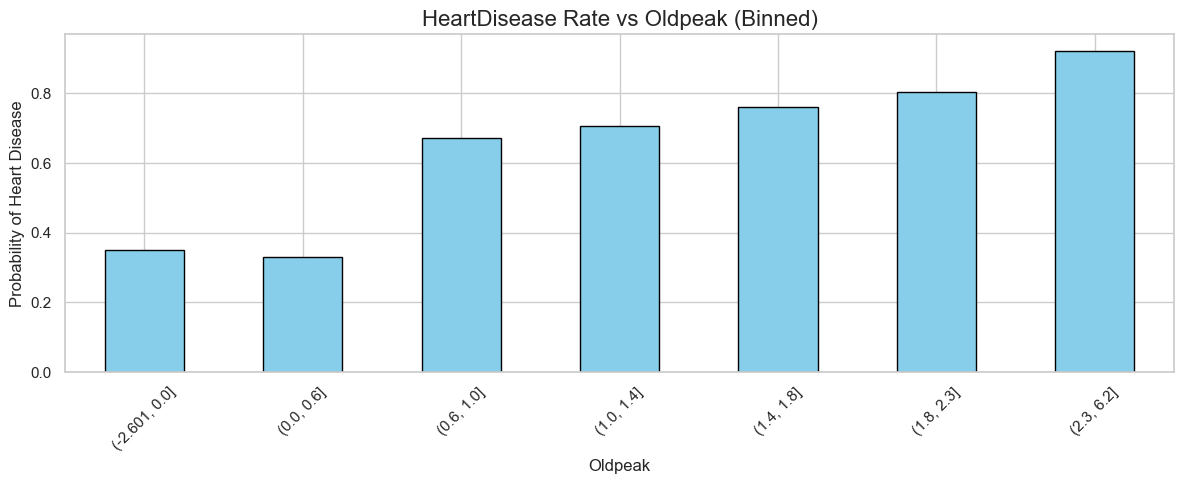

In [8]:
for col in numeric_cols:
    try:
        df_copy["bin"] = pd.qcut(df_copy[col], q=10, duplicates="drop")

        mean_vals = df_copy.groupby("bin")["HeartDisease"].mean()

        plt.figure(figsize=(12, 5))
        mean_vals.plot(kind='bar', color="skyblue", edgecolor="black")
        plt.title(f"HeartDisease Rate vs {col} (Binned)", fontsize=16)
        plt.ylabel("Probability of Heart Disease")
        plt.xlabel(col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"HeartDisease Rate vs {col} (Binned).pdf", format='pdf')
        plt.show()
    except Exception as e:
        print(f"Failed to bin {col}: {e}")


# Feature Engineering

## 1. Bin Operation(Age, Oldpeak, MaxHR)

In [9]:
# Bin Age, 0-45, 45-55, 55-100
def bin_age(df: pd.DataFrame) -> pd.DataFrame:
    df["Age_bin"] = pd.cut(
        df["Age"],
        bins=[0, 45, 55, 100],
        labels=["Young", "Middle", "Senior"],
        include_lowest=True
    )
    return df

# Bin Oldpeak, -10-0.6, 0.6-10
def bin_oldpeak(df: pd.DataFrame) -> pd.DataFrame:
    df["Oldpeak_bin"] = pd.cut(
        df["Oldpeak"],
        bins=[-10, 0.6, 10],
        labels=["LowST", "HighST"],
        include_lowest=True
    )
    return df

# Bin MaxHR, 0-130, 130-151, 151-300
def bin_maxhr(df: pd.DataFrame) -> pd.DataFrame:
    df["MaxHR_bin"] = pd.cut(
        df["MaxHR"],
        bins=[0, 130, 151, 300],
        labels=["LowHR", "MidHR", "HighHR"],
        include_lowest=True
    )
    return df

## 2. Address null value in Cholesterol Feature

### 1. Basic Preperation

In [10]:
df["Cholesterol"] = df["Cholesterol"].replace(0, np.nan)
df["Cholesterol_missing"] = df["Cholesterol"].isna().astype(int)

### 2. Filling with Median

In [11]:
# Fill the 0 value of Cholesterol Level (such condition may indicate a missing) with Median as the baseline
def median_impute_cholesterol(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Baseline: fill missing Cholesterol using TRAIN median only (avoid leakage)
    """
    train_out = train_df.copy()
    test_out = test_df.copy()

    med = train_out["Cholesterol"].median()
    train_out["Cholesterol"] = train_out["Cholesterol"].fillna(med)
    test_out["Cholesterol"] = test_out["Cholesterol"].fillna(med)

    return train_out, test_out, med

### 3. Filling with Regression (RF)

In [13]:
def build_chol_regression_pipeline(model=None) -> Pipeline:
    """
    Pipeline: preprocess (OHE for cat, passthrough for num) + regressor
    Note: Does NOT use HeartDisease.
    """
    if model is None:
        model = RandomForestRegressor(
            n_estimators=600,
            random_state=42,
            n_jobs=-1
        )

    cat_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]
    num_cols = ["Age", "RestingBP", "MaxHR", "Oldpeak", "Cholesterol_missing"]  # 0/1, treat as numeric

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
            ("num", "passthrough", num_cols),
        ],
        remainder="drop"
    )

    pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("model", model)
    ])
    return pipe

def fit_chol_regressor_with_cv(train_df: pd.DataFrame, n_splits: int = 5, random_state: int = 42):
    """
    Fit a cholesterol regressor ONLY on train observed (non-missing Cholesterol),
    with K-fold CV evaluation on the same observed subset.
    Returns:
      - fitted pipeline on ALL observed train data
      - cv summary (mean/std for RMSE & R2)
    """
    # Only observed cholesterol samples for training/regression evaluation
    df_obs = train_df[train_df["Cholesterol"].notna()].copy()

    X_cols = ["Age", "Sex", "ChestPainType", "RestingBP", "FastingBS",
              "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope",
              "Cholesterol_missing"]
    X = df_obs[X_cols]
    y = df_obs["Cholesterol"].astype(float)

    pipe = build_chol_regression_pipeline()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # cross_validate gives multiple metrics + fit_time/score_time
    cv_results = cross_validate(
        pipe, X, y,
        cv=kf,
        scoring={
            "rmse": "neg_root_mean_squared_error",
            "r2": "r2"
        },
        n_jobs=-1,
        return_train_score=False
    )

    # Summarize (rmse is negative in sklearn scoring)
    rmse_scores = -cv_results["test_rmse"]
    r2_scores = cv_results["test_r2"]

    cv_summary = {
        "n_obs_train": len(df_obs),
        "rmse_mean": float(np.mean(rmse_scores)),
        "rmse_std": float(np.std(rmse_scores)),
        "r2_mean": float(np.mean(r2_scores)),
        "r2_std": float(np.std(r2_scores)),
    }

    # Fit final model on ALL observed train data
    pipe.fit(X, y)

    return pipe, cv_summary

def apply_chol_regression_imputation(df_part: pd.DataFrame, fitted_pipe: Pipeline) -> pd.DataFrame:
    """
    Use the fitted regression pipeline to impute missing Cholesterol in a dataframe split (train or test).
    IMPORTANT: fitted_pipe must be trained only on training observed data to avoid leakage.
    """
    df_out = df_part.copy()

    X_cols = ["Age", "Sex", "ChestPainType", "RestingBP", "FastingBS",
              "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope",
              "Cholesterol_missing"]

    mask_mis = df_out["Cholesterol"].isna()
    if mask_mis.any():
        df_out.loc[mask_mis, "Cholesterol"] = fitted_pipe.predict(df_out.loc[mask_mis, X_cols])

    return df_out

### 4. Drop all Null Value

In [14]:
def drop_missing_cholesterol(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Drop strategy: remove rows where Cholesterol is missing (NaN).
    Note: This will change sample size and potentially class balance.
    """
    train_out = train_df[train_df["Cholesterol"].notna()].copy()
    test_out  = test_df[test_df["Cholesterol"].notna()].copy()

    return train_out, test_out, len(train_out), len(test_out)

## 3. Feature Engineering for Linear Model

In [15]:
def feature_engineering_linear(df: pd.DataFrame, scaler=None, fit_scaler: bool = True):
    """
    Linear model FE:
    - One-hot encoding for categorical + binned vars
    - Standardize numerical columns using scaler
    """
    y = df["HeartDisease"].astype(int)

    cat_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]
    num_cols = ["RestingBP", "Cholesterol"]

    df_fe = df.copy()
    df_fe = bin_age(df_fe)
    df_fe = bin_oldpeak(df_fe)
    df_fe = bin_maxhr(df_fe)

    bin_cols = ["Age_bin", "Oldpeak_bin", "MaxHR_bin"]

    # Drop original continuous vars (your original design)
    df_fe = df_fe.drop(columns=["Age", "MaxHR", "Oldpeak"])

    all_cat_cols = cat_cols + bin_cols
    df_fe = pd.get_dummies(df_fe, columns=all_cat_cols, drop_first=True)

    if scaler is None:
        scaler = StandardScaler()

    if fit_scaler:
        df_fe[num_cols] = scaler.fit_transform(df_fe[num_cols])
    else:
        df_fe[num_cols] = scaler.transform(df_fe[num_cols])

    X_processed = df_fe.drop(columns=["HeartDisease"])
    return X_processed, y, scaler

## 4. Feature Engineering for Tree-Based Model

In [16]:
def feature_engineering_tree_train(df_tr: pd.DataFrame):
    """
    Tree-model feature engineering (TRAIN):
    - Fit OneHotEncoder on categorical columns (For SHAP Analysis)
    - Transform to OHE matrix
    - Return X (DataFrame), y (Series), and fitted encoder info
    """
    df_tr = df_tr.copy()

    y_tr = df_tr["HeartDisease"].astype(int)
    X_tr_raw = df_tr.drop(columns=["HeartDisease"])

    cat_cols = ["Sex","ChestPainType","FastingBS","RestingECG","ExerciseAngina","ST_Slope"]
    num_cols = [c for c in X_tr_raw.columns if c not in cat_cols]

    # If sklearn is old, change sparse_output=False -> sparse=False
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    ohe.fit(X_tr_raw[cat_cols])

    X_cat = ohe.transform(X_tr_raw[cat_cols])
    cat_names = ohe.get_feature_names_out(cat_cols)

    X_num = X_tr_raw[num_cols].to_numpy()

    X_tr = np.hstack([X_num, X_cat])
    feature_names = list(num_cols) + list(cat_names)

    X_tr = pd.DataFrame(X_tr, columns=feature_names, index=df_tr.index)

    encoder_info = {
        "ohe": ohe,
        "cat_cols": cat_cols,
        "num_cols": num_cols,
        "feature_names": feature_names
    }

    return X_tr, y_tr, encoder_info

def feature_engineering_tree_test(df_te: pd.DataFrame, encoder_info):
    """
    Tree-model feature engineering (TEST):
    - Use fitted OneHotEncoder from train
    - Transform test and ensure same column order
    """
    df_te = df_te.copy()

    y_te = df_te["HeartDisease"].astype(int)
    X_te_raw = df_te.drop(columns=["HeartDisease"])

    ohe = encoder_info["ohe"]
    cat_cols = encoder_info["cat_cols"]
    num_cols = encoder_info["num_cols"]
    feature_names = encoder_info["feature_names"]

    X_cat = ohe.transform(X_te_raw[cat_cols])
    cat_names = ohe.get_feature_names_out(cat_cols)

    X_num = X_te_raw[num_cols].to_numpy()

    X_te = np.hstack([X_num, X_cat])
    feature_names_te = list(num_cols) + list(cat_names)

    X_te = pd.DataFrame(X_te, columns=feature_names_te, index=df_te.index)

    # IMPORTANT: align test columns to train columns order
    X_te = X_te.reindex(columns=feature_names, fill_value=0)

    return X_te, y_te


## 5. Train-Test Split

In [17]:
df_train, df_test = train_test_split(
    df, test_size=0.4, random_state=42, stratify=df["HeartDisease"]
)

# Filling with Median
df_train_med, df_test_med, chol_median = median_impute_cholesterol(df_train, df_test)
print("\n===== Baseline Median Imputation =====")
print("Train median Cholesterol:", chol_median)
print("Missing in train:", int(df_train["Cholesterol"].isna().sum()), "| Missing in test:", int(df_test["Cholesterol"].isna().sum()))

# Filling with Regression
chol_pipe, cv_summary = fit_chol_regressor_with_cv(df_train, n_splits=5, random_state=42)
df_train_reg = apply_chol_regression_imputation(df_train, chol_pipe)
df_test_reg = apply_chol_regression_imputation(df_test, chol_pipe)

print("\n===== Regression Imputation (RF) w/ 5-Fold CV on TRAIN observed =====")
print("CV summary:", cv_summary)

# Drop
df_train_drop, df_test_drop, ntr, nte = drop_missing_cholesterol(df_train, df_test)
print("\n===== Drop Missing Cholesterol =====")
print("Train size after drop:", ntr, "| Test size after drop:", nte)


===== Baseline Median Imputation =====
Train median Cholesterol: 237.0
Missing in train: 98 | Missing in test: 74

===== Regression Imputation (RF) w/ 5-Fold CV on TRAIN observed =====
CV summary: {'n_obs_train': 452, 'rmse_mean': 55.803300986446814, 'rmse_std': 6.380016686443185, 'r2_mean': -0.11405253366083157, 'r2_std': 0.05918388293248403}

===== Drop Missing Cholesterol =====
Train size after drop: 452 | Test size after drop: 294


# Modeling(Including Model Evaluation)

## 1. Logistic Regression

In [18]:
def run_logistic_regression(df_tr: pd.DataFrame, df_te: pd.DataFrame, title: str):
    X_tr, y_tr, scaler = feature_engineering_linear(df_tr, scaler=None, fit_scaler=True)
    X_te, y_te, _ = feature_engineering_linear(df_te, scaler=scaler, fit_scaler=False)

    log_reg = LogisticRegression(max_iter=2000, solver="liblinear")

    param_grid = {"penalty": ["l1", "l2"], "C": [0.001, 0.01, 0.1, 1, 10, 100]}
    grid = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1
    )
    grid.fit(X_tr, y_tr)
    best_model = grid.best_estimator_

    y_train_pred = best_model.predict(X_tr)
    y_train_prob = best_model.predict_proba(X_tr)[:, 1]

    y_test_pred = best_model.predict(X_te)
    y_test_prob = best_model.predict_proba(X_te)[:, 1]

    print(f"\n===== Logistic Regression ({title}) =====")
    print("Best Params:", grid.best_params_)
    print("Train Accuracy:", accuracy_score(y_tr, y_train_pred))
    print("Test Accuracy:", accuracy_score(y_te, y_test_pred))
    print("Train F1:", f1_score(y_tr, y_train_pred))
    print("Test F1:", f1_score(y_te, y_test_pred))
    print("Train ROC AUC:", roc_auc_score(y_tr, y_train_prob))
    print("Test ROC AUC:", roc_auc_score(y_te, y_test_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_test_pred))

    coef_df = pd.DataFrame({
        "Feature": X_tr.columns,
        "Coefficient": best_model.coef_[0]
    }).sort_values(by="Coefficient", ascending=False)

    print(coef_df)

    # ROC Curve
    fpr_test, tpr_test, _ = roc_curve(y_te, y_test_prob)
    auc_test = auc(fpr_test, tpr_test)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.3f})", linewidth=2)

    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

    plt.title(f"ROC Curve - Logistic Regression ({title})", fontsize=16)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.savefig(f'Logistic ROC ({title}).pdf', format='pdf')
    plt.show()

    return roc_auc_score(y_te, y_test_prob)


===== Logistic Regression (Median Impute) =====
Best Params: {'C': 1, 'penalty': 'l1'}
Train Accuracy: 0.8690909090909091
Test Accuracy: 0.8668478260869565
Train F1: 0.8827361563517915
Test F1: 0.8790123456790123
Train ROC AUC: 0.9356413136499786
Test ROC AUC: 0.9285927785748446
Confusion Matrix:
 [[141  23]
 [ 26 178]]
                Feature  Coefficient
2   Cholesterol_missing     1.409535
3                 Sex_M     1.273299
7           FastingBS_1     0.849933
10     ExerciseAngina_Y     0.767033
15   Oldpeak_bin_HighST     0.482414
14       Age_bin_Senior     0.239810
11        ST_Slope_Flat     0.082553
1           Cholesterol     0.019108
9         RestingECG_ST     0.000000
13       Age_bin_Middle     0.000000
0             RestingBP    -0.019802
8     RestingECG_Normal    -0.025843
16      MaxHR_bin_MidHR    -0.363747
17     MaxHR_bin_HighHR    -0.381855
6      ChestPainType_TA    -1.230440
5     ChestPainType_NAP    -1.579184
4     ChestPainType_ATA    -1.747258
12         

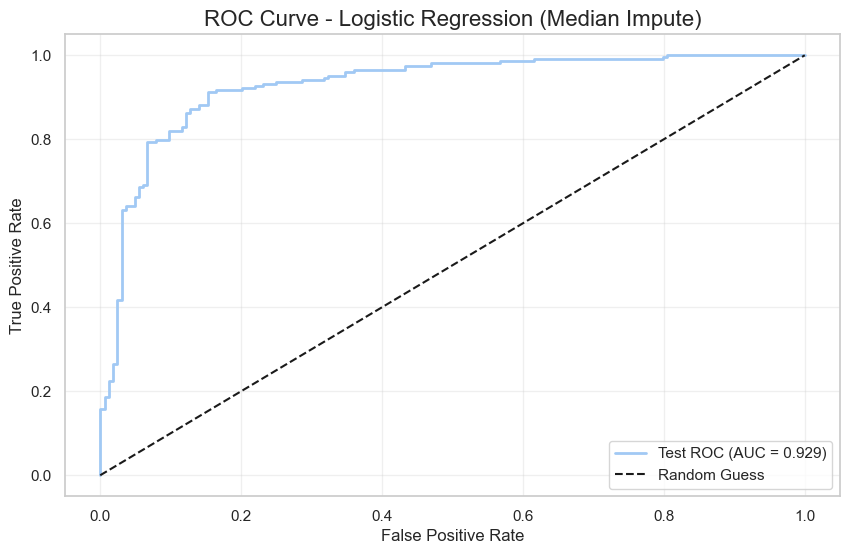


===== Logistic Regression (Regression Impute (RF)) =====
Best Params: {'C': 1, 'penalty': 'l1'}
Train Accuracy: 0.8690909090909091
Test Accuracy: 0.8668478260869565
Train F1: 0.8827361563517915
Test F1: 0.8790123456790123
Train ROC AUC: 0.9356680573384681
Test ROC AUC: 0.9291606886657102
Confusion Matrix:
 [[141  23]
 [ 26 178]]
                Feature  Coefficient
2   Cholesterol_missing     1.407054
3                 Sex_M     1.277945
7           FastingBS_1     0.845860
10     ExerciseAngina_Y     0.765317
15   Oldpeak_bin_HighST     0.480063
14       Age_bin_Senior     0.243764
11        ST_Slope_Flat     0.078478
1           Cholesterol     0.036862
9         RestingECG_ST     0.000000
13       Age_bin_Middle     0.000000
0             RestingBP    -0.021873
8     RestingECG_Normal    -0.025818
16      MaxHR_bin_MidHR    -0.363505
17     MaxHR_bin_HighHR    -0.384919
6      ChestPainType_TA    -1.231853
5     ChestPainType_NAP    -1.574554
4     ChestPainType_ATA    -1.749361
12

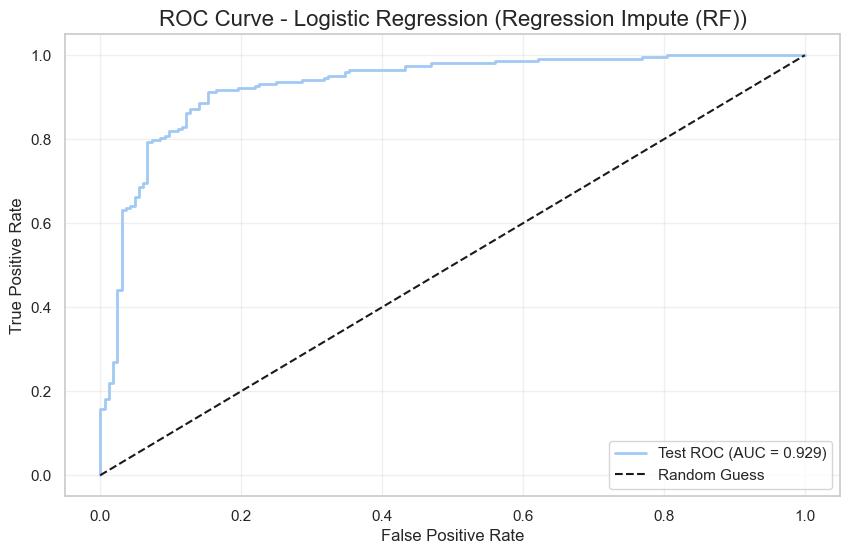


===== Logistic Regression (Drop Missing) =====
Best Params: {'C': 1, 'penalty': 'l1'}
Train Accuracy: 0.8584070796460177
Test Accuracy: 0.8673469387755102
Train F1: 0.8552036199095022
Test F1: 0.8560885608856088
Train ROC AUC: 0.9293067947838023
Test ROC AUC: 0.9345091668600604
Confusion Matrix:
 [[139  16]
 [ 23 116]]
                Feature  Coefficient
3                 Sex_M     1.376353
10     ExerciseAngina_Y     0.829238
15   Oldpeak_bin_HighST     0.458640
14       Age_bin_Senior     0.445880
7           FastingBS_1     0.128312
0             RestingBP     0.088514
1           Cholesterol     0.038632
13       Age_bin_Middle     0.000000
11        ST_Slope_Flat     0.000000
9         RestingECG_ST     0.000000
2   Cholesterol_missing     0.000000
8     RestingECG_Normal    -0.187724
17     MaxHR_bin_HighHR    -0.266139
16      MaxHR_bin_MidHR    -0.293418
5     ChestPainType_NAP    -1.255710
6      ChestPainType_TA    -1.348614
4     ChestPainType_ATA    -1.673420
12          

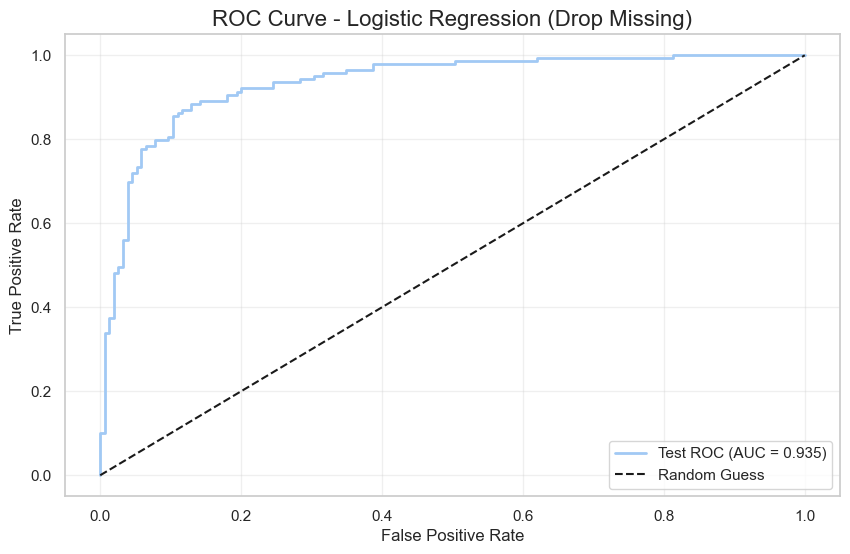

In [19]:
auc_lr_med = run_logistic_regression(df_train_med, df_test_med, "Median Impute")
auc_lr_reg = run_logistic_regression(df_train_reg, df_test_reg, "Regression Impute (RF)")
auc_lr_drop = run_logistic_regression(df_train_drop, df_test_drop, "Drop Missing")

## 2. Tree-Based Model (RF & XGB)

In [20]:
def _group_ohe_shap_and_X(X_ohe: pd.DataFrame, shap_vals: np.ndarray, cat_groups: dict):
    """
    Aggregate OHE columns back to original categorical variables.

    Inputs:
      - X_ohe: DataFrame after OHE (same columns as shap_vals feature axis)
      - shap_vals: (n_samples, n_features)
      - cat_groups: dict like {"ChestPainType": "ChestPainType_", ...}
                   where value is the prefix of OHE columns

    Outputs:
      - X_grp: DataFrame with:
            numeric columns kept as-is,
            + one aggregated column per categorical group (coded as category index)
      - shap_grp: (n_samples, n_grp_features) where:
            numeric features keep their SHAP,
            categorical group SHAP = sum of SHAP over its dummy columns
    """
    X_grp_parts = []
    shap_grp_parts = []
    feat_names = []

    used_cols = set()

    # 1) keep non-OHE columns (numeric / passthrough)
    # We treat columns that do NOT start with any prefix as numeric.
    prefixes = tuple(cat_groups.values())
    num_cols = [c for c in X_ohe.columns if not c.startswith(prefixes)]
    if len(num_cols) > 0:
        X_grp_parts.append(X_ohe[num_cols])
        shap_grp_parts.append(shap_vals[:, [X_ohe.columns.get_loc(c) for c in num_cols]])
        feat_names += num_cols
        used_cols.update(num_cols)

    # 2) aggregate each categorical group
    for group_name, prefix in cat_groups.items():
        grp_cols = [c for c in X_ohe.columns if c.startswith(prefix)]
        if len(grp_cols) == 0:
            continue

        idxs = [X_ohe.columns.get_loc(c) for c in grp_cols]

        # aggregated SHAP: sum across dummies
        shap_sum = shap_vals[:, idxs].sum(axis=1, keepdims=True)
        shap_grp_parts.append(shap_sum)
        feat_names.append(group_name)

        # aggregated "feature value" for coloring:
        # encode category as an integer:
        # - if one dummy is 1 -> its position (1..K)
        # - if all 0 -> 0 (this corresponds to the dropped baseline IF you used drop='first')
        X_sub = X_ohe[grp_cols].to_numpy()
        # argmax gives 0..K-1 even when all zeros, so we need a mask
        any_one = X_sub.sum(axis=1) > 0
        cat_code = np.zeros(X_sub.shape[0], dtype=int)
        cat_code[any_one] = (np.argmax(X_sub[any_one], axis=1) + 1)
        X_grp_parts.append(pd.DataFrame({group_name: cat_code}, index=X_ohe.index))

        used_cols.update(grp_cols)

    X_grp = pd.concat(X_grp_parts, axis=1)
    shap_grp = np.concatenate(shap_grp_parts, axis=1)

    # ensure column order matches feat_names
    X_grp = X_grp[feat_names]

    return X_grp, shap_grp

def _shap_plots_for_tree_model(model, X_tr, X_te, title, model_tag,
                               max_display=15, top_dep_k=3):
    # sample
    X_bg = X_tr.sample(n=min(300, len(X_tr)), random_state=42)
    X_show = X_te.sample(n=min(400, len(X_te)), random_state=42)

    # Use predict_proba so SHAP explains probability; then pick class=1
    explainer = shap.Explainer(model.predict_proba, X_bg)
    sv = explainer(X_show)

    # sv.values is (n_samples, n_features, n_classes) in many versions
    vals = sv.values

    # handle different shapes robustly
    vals = np.array(vals)

    if vals.ndim == 3:
        # (n_samples, n_features, n_classes) -> take positive class (1)
        shap_vals = vals[:, :, 1]
    elif vals.ndim == 2:
        # already (n_samples, n_features)
        shap_vals = vals
    else:
        raise ValueError(f"{model_tag}: unexpected SHAP values shape {vals.shape}")

    shap_vals = np.array(shap_vals)
    if shap_vals.ndim == 2 and shap_vals.shape[0] == X_show.shape[1] and shap_vals.shape[1] == X_show.shape[0]:
        shap_vals = shap_vals.T

    if shap_vals.shape[1] != X_show.shape[1]:
        raise ValueError(f"{model_tag}: shap_vals {shap_vals.shape} vs X_show {X_show.shape}")

    # ---- OHE summary ----
    plt.figure()
    shap.summary_plot(shap_vals, X_show, show=False, max_display=max_display)
    plt.title(f"SHAP Summary (Beeswarm, OHE) - {model_tag} ({title})")
    plt.tight_layout()
    plt.savefig(f"SHAP Summary Beeswarm (OHE) - {model_tag} ({title}).pdf")
    plt.show()

    plt.figure()
    shap.summary_plot(shap_vals, X_show, plot_type="bar", show=False, max_display=max_display)
    plt.title(f"SHAP Summary (Bar, OHE) - {model_tag} ({title})")
    plt.tight_layout()
    plt.savefig(f"SHAP Summary Bar (OHE) - {model_tag} ({title}).pdf")
    plt.show()

    # ---- dependence (top-k) ----
    # mean_abs = np.abs(shap_vals).mean(axis=0)
    # top_idx = np.argsort(mean_abs)[::-1][:top_dep_k]
    # top_features = [X_show.columns[i] for i in top_idx]
    #
    # for feat in top_features:
    #     try:
    #         inter = shap.utils.approximate_interactions(feat, shap_vals, X_show)
    #         inter_feat = inter[0] if len(inter) > 0 else None
    #     except Exception:
    #         inter_feat = None
    #
    #     plt.figure()
    #     shap.dependence_plot(feat, shap_vals, X_show, interaction_index=inter_feat, show=False)
    #     plt.title(f"SHAP Dependence - {feat} | {model_tag} ({title})")
    #     plt.tight_layout()
    #     plt.savefig(f"SHAP Dependence - {feat} - {model_tag} ({title}).pdf")
    #     plt.show()

    # ---- Aggregated summary (optional) ----
    cat_groups = {
        "Sex": "Sex_",
        "ChestPainType": "ChestPainType_",
        "FastingBS": "FastingBS_",
        "RestingECG": "RestingECG_",
        "ExerciseAngina": "ExerciseAngina_",
        "ST_Slope": "ST_Slope_",
    }
    X_grp, shap_grp = _group_ohe_shap_and_X(X_show, shap_vals, cat_groups)

    plt.figure()
    shap.summary_plot(shap_grp, X_grp, show=False, max_display=max_display)
    plt.title(f"SHAP Summary (Beeswarm, Aggregated) - {model_tag} ({title})")
    plt.tight_layout()
    plt.savefig(f"SHAP Summary Beeswarm (Aggregated) - {model_tag} ({title}).pdf")
    plt.show()

    plt.figure()
    shap.summary_plot(shap_grp, X_grp, plot_type="bar", show=False, max_display=max_display)
    plt.title(f"SHAP Summary (Bar, Aggregated) - {model_tag} ({title})")
    plt.tight_layout()
    plt.savefig(f"SHAP Summary Bar (Aggregated) - {model_tag} ({title}).pdf")
    plt.show()

    # ---- dependence (top-k) for AGGREGATED only ----
    mean_abs_grp = np.abs(shap_grp).mean(axis=0)
    top_idx_grp = np.argsort(mean_abs_grp)[::-1][:top_dep_k]
    top_features_grp = [X_grp.columns[i] for i in top_idx_grp]

    for feat in top_features_grp:
        # try to pick an interaction feature in aggregated space (optional)
        try:
            inter = shap.utils.approximate_interactions(feat, shap_grp, X_grp)
            inter_feat = inter[0] if len(inter) > 0 else None
        except Exception:
            inter_feat = None

        plt.figure()
        shap.dependence_plot(feat, shap_grp, X_grp, interaction_index=inter_feat, show=False)
        plt.title(f"SHAP Dependence (Aggregated) - {feat} | {model_tag} ({title})")
        plt.tight_layout()
        plt.savefig(f"SHAP Dependence (Aggregated) - {feat} - {model_tag} ({title}).pdf")
        plt.show()

def shap_for_rf(best_rf, X_tr, X_te, title):
    _shap_plots_for_tree_model(best_rf, X_tr, X_te, title, model_tag="RandomForest")

def shap_for_xgb(best_xgb, X_tr, X_te, title):
    _shap_plots_for_tree_model(best_xgb, X_tr, X_te, title, model_tag="XGBoost")

In [21]:
def run_tree_models(df_tr: pd.DataFrame, df_te: pd.DataFrame, title: str):
    X_tr, y_tr, encoders = feature_engineering_tree_train(df_tr)
    X_te, y_te = feature_engineering_tree_test(df_te, encoders)

    # RF Classifier
    rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    )

    param_grid_rf = {
        "n_estimators": [200, 400, 600],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    }

    grid_rf = GridSearchCV(
        estimator=rf,
        param_grid=param_grid_rf,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_rf.fit(X_tr, y_tr)

    best_rf = grid_rf.best_estimator_
    print(f"\n===== Random Forest ({title})=====")
    print(grid_rf.best_params_)
    print("Best CV AUC:", grid_rf.best_score_)

    y_tr_pred_rf = best_rf.predict(X_tr)
    y_tr_prob_rf = best_rf.predict_proba(X_tr)[:, 1]
    y_te_pred_rf = best_rf.predict(X_te)
    y_te_prob_rf = best_rf.predict_proba(X_te)[:, 1]

    print("Accuracy (train):", accuracy_score(y_tr, y_tr_pred_rf))
    print("Accuracy (test):", accuracy_score(y_te, y_te_pred_rf))
    print("F1 (train):      ", f1_score(y_tr, y_tr_pred_rf))
    print("F1 (test):      ", f1_score(y_te, y_te_pred_rf))
    print("ROC AUC (train): ", roc_auc_score(y_tr, y_tr_prob_rf))
    print("ROC AUC (test): ", roc_auc_score(y_te, y_te_prob_rf))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_te_pred_rf))

    # Feature Importance
    importances_rf = pd.Series(best_rf.feature_importances_, index=X_tr.columns)
    importances_rf = importances_rf.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    importances_rf.head(15).plot(kind="bar")
    plt.title(f"Random Forest - Top 15 Feature Importances ({title})")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.savefig(f'RF Importance ({title}).pdf', format='pdf')
    plt.show()

    # ========== SHAP: Random Forest ==========
    shap_for_rf(best_rf, X_tr, X_te, title)

    # XGB Classifier
    xgb_clf = XGBClassifier(
        random_state=42,
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        tree_method="auto"
    )

    param_grid_xgb = {
        "n_estimators": [200, 400],
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.1, 0.3],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }

    grid_xgb = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid_xgb,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_xgb.fit(X_tr, y_tr)

    best_xgb = grid_xgb.best_estimator_
    print(f"\n===== XGBoost ({title})) =====")
    print(grid_xgb.best_params_)
    print("Best CV AUC:", grid_xgb.best_score_)

    y_tr_pred_xgb = best_xgb.predict(X_tr)
    y_tr_prob_xgb = best_xgb.predict_proba(X_tr)[:, 1]
    y_te_pred_xgb = best_xgb.predict(X_te)
    y_te_prob_xgb = best_xgb.predict_proba(X_te)[:, 1]

    print("Accuracy (train):", accuracy_score(y_tr, y_tr_pred_xgb))
    print("Accuracy (test):", accuracy_score(y_te, y_te_pred_xgb))
    print("F1 (train):      ", f1_score(y_tr, y_tr_pred_xgb))
    print("F1 (test):      ", f1_score(y_te, y_te_pred_xgb))
    print("ROC AUC (train): ", roc_auc_score(y_tr, y_tr_prob_xgb))
    print("ROC AUC (test): ", roc_auc_score(y_te, y_te_prob_xgb))
    print("Confusion Matrix:\n", confusion_matrix(y_te, y_te_pred_xgb))

    importances_xgb = pd.Series(best_xgb.feature_importances_, index=X_tr.columns)
    importances_xgb = importances_xgb.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    importances_xgb.head(15).plot(kind="bar")
    plt.title(f"XGBoost - Top 15 Feature Importances ({title})")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.savefig(f'XGB Importance ({title}).pdf', format='pdf')
    plt.show()

    # ========== SHAP: XGBoost ==========
    shap_for_xgb(best_xgb, X_tr, X_te, title)

    # ========== ROC Curve: RF vs XGB ==========
    fpr_rf, tpr_rf, _ = roc_curve(y_te, y_te_prob_rf)
    auc_rf = auc(fpr_rf, tpr_rf)

    fpr_xgb, tpr_xgb, _ = roc_curve(y_te, y_te_prob_xgb)
    auc_xgb = auc(fpr_xgb, tpr_xgb)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linewidth=2)
    plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})", linewidth=2)

    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.title(f"ROC Curve Comparison: RF vs XGB ({title})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'RF & XGB ROC ({title}).pdf', format='pdf')
    plt.show()

    return auc_rf, auc_xgb

In [ ]:
auc_rf_med, auc_xgb_med = run_tree_models(df_train_med, df_test_med, "Median Impute")
auc_rf_reg, auc_xgb_reg = run_tree_models(df_train_reg, df_test_reg, "Regression Impute (RF)")
auc_rf_drop, auc_xgb_drop = run_tree_models(df_train_drop, df_test_drop, "Drop Missing")